# Rmax_evaluation_TCRM

Rmax (radius of maximum winds), is the distance between the centre of a cyclone and its band of strongest wind. In a strong cyclone, Rmax tends to be a small value, i.e. the maximum winds are close to the eye. As a cyclone weakens, the Rmax value will increase. 

The stochastic instance of GA's TCRM generates a given number of random cyclone tracks, and assigns parameters, including Rmax, from a distribution of cyclone observations. In addition to the observed distribution, a random number (also from a given distribution), is applied to the Rmax values. This ensures that values not seen within the observational record, but that may be equally as valid, can also be modelled. 

As of May 2017, TCRM v 2.0 does not do a good job of handling instances where the assigned Rmax value is too large. In `/wind/windmodels.py`, within the Holland Profile class, the second derivative of Rmax is calculated to validate the Rmax wind profile: if $f"(Rmax) < 0$, then the radial wind profile is convex, and has a valid shape, with a local maximum (Rmax) present. Where $f"(Rmax) \geqslant 0$, a local maximum is not present, and the radial wind profile is unrealistic (i.e. the maximum wind speed band is in the last value of the profile, and therefore not properly resolved).

At present, when $f"(Rmax) \geqslant 0$, the TCRM run will fail. There is currently no means for testing for a realistic Rmax value and therefore, limiting the occurrence of this error. Within `/TrackGenerator/TrackGenerator.py` are a number of tests that are applied to the generated tracks to ensure that they are valid. Within `validSize`, a lower bound of Rmax is stipulated that must be met for a valid track. 

In the first instance, we will address the second derivative error by placing an additional upper bounds within this filter function.

Written by Claire Krause, May 2017.

# 1. Using observational data from IBTrACS

The IBTrACS database will be interrogated to find the limit of realistic Rmax values. This will be used to inform the generation of a realistic Rmax upper bound.

Note that the rmax values within the IBTrACS database are recorded in nautical miles (nm).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get the IBTRaCS dataset
url = 'ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r09/all/csv/Allstorms.ibtracs_all.v03r09.csv.gz'
ibtracs = pd.read_csv(url, delimiter = ',', compression = 'gzip', low_memory = False, skiprows = 3,
                      names = ['Serial_Num', 'Season', 'Basin', 'ISO_time', 'Latitude_for_mapping', 
                               'Longitude_for_mapping', 'reunion_rmw', 'atcf_rmw', 'jtwc_??_rmw'],
                      usecols = [0, 1, 3, 6, 16, 17, 149, 162, 184], na_values = -999.)
# We need to rename 'jtwc_??_rmw' to make it easier to call this column
ibtracs.columns = ['Serial_Num', 'Season', 'Basin', 'ISO_time', 'Latitude_for_mapping', 
                               'Longitude_for_mapping', 'reunion_rmw', 'atcf_rmw', 'jtwc_rmw']
ibtracs

,Serial_Num,Season,Basin,ISO_time,Latitude_for_mapping,Longitude_for_mapping,reunion_rmw,atcf_rmw,jtwc_rmw
0,1842298N11080,1842,NI,1842-10-25 06:00:00,10.87,79.83,NaN,NaN,NaN
1,1842298N11080,1842,NI,1842-10-25 12:00:00,10.82,78.88,NaN,NaN,NaN
2,1842298N11080,1842,NI,1842-10-25 18:00:00,10.79,77.92,NaN,NaN,NaN
3,1842298N11080,1842,NI,1842-10-26 00:00:00,10.79,76.93,NaN,NaN,NaN
4,1842298N11080,1842,NI,1842-10-26 06:00:00,10.81,75.84,NaN,NaN,NaN
5,1842298N11080,1842,NI,1842-10-26 12:00:00,10.86,74.68,NaN,NaN,NaN
6,1842298N11080,1842,NI,1842-10-26 18:00:00,10.96,73.53,NaN,NaN,NaN
7,1842298N11080,1842,NI,1842-10-27 00:00:00,11.12,72.42,NaN,NaN,NaN
8,1842298N11080,1842,NI,1842-10-27 06:00:00,11.25,71.41,NaN,NaN,NaN
9,1842298N11080,1842,NI,1842-10-27 12:00:00,11.35,70.47,NaN,NaN,NaN


In [3]:
# To save memory, lets throw away all the rows that don't have any Rmax values
ibtracs_small = ibtracs.dropna(thresh = 7) #where there is at least one non-nan Rmax value
ibtracs_small

,Serial_Num,Season,Basin,ISO_time,Latitude_for_mapping,Longitude_for_mapping,reunion_rmw,atcf_rmw,jtwc_rmw
291,1851175N26270,1851,NA,1851-06-25 00:00:00,27.53,-94.27,NaN,0.0,NaN
292,1851175N26270,1851,NA,1851-06-25 06:00:00,27.75,-95.00,NaN,0.0,NaN
293,1851175N26270,1851,NA,1851-06-25 12:00:00,27.88,-95.68,NaN,0.0,NaN
294,1851175N26270,1851,NA,1851-06-25 18:00:00,28.03,-96.27,NaN,0.0,NaN
296,1851175N26270,1851,NA,1851-06-26 00:00:00,28.17,-96.80,NaN,0.0,NaN
297,1851175N26270,1851,NA,1851-06-26 06:00:00,28.30,-97.40,NaN,0.0,NaN
298,1851175N26270,1851,NA,1851-06-26 12:00:00,28.43,-98.10,NaN,0.0,NaN
299,1851175N26270,1851,NA,1851-06-26 18:00:00,28.63,-98.73,NaN,0.0,NaN
300,1851175N26270,1851,NA,1851-06-27 00:00:00,29.00,-99.32,NaN,0.0,NaN
301,1851175N26270,1851,NA,1851-06-27 06:00:00,29.48,-99.80,NaN,0.0,NaN


## Plot up the Rmax values for all basins

<IPython.core.display.Javascript object>


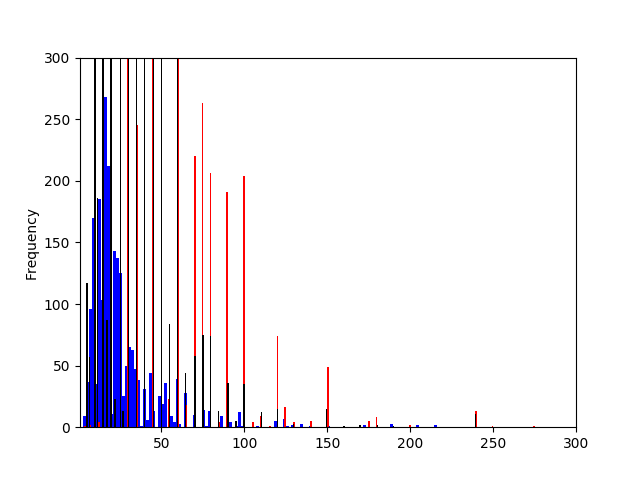

(0, 300)

In [4]:
# Get where values are not nan
reunion = ibtracs_small[ibtracs_small.reunion_rmw.notnull()]
atcf = ibtracs_small[ibtracs_small.atcf_rmw.notnull()]
jtwc = ibtracs_small[ibtracs_small.jtwc_rmw.notnull()]

fig = plt.figure()
reunion.reunion_rmw.plot.hist(bins = 299, color = 'blue')
atcf.atcf_rmw.plot.hist(bins = 299, color = 'red')
jtwc.jtwc_rmw.plot.hist(bins = 299, color = 'black')
plt.xlim([1,300]) # ignore where = 0
plt.ylim([0, 300]) # we only care about the extremes, so keep it small

It is clear from this histogram that most Rmax values do not exceed 200 nm (~370 km). There are however, a small number of Rmax values as high as 204, 215, 239, 249 and 274 nm (507 km) were observed.

# 2. Using run data from TCRM

While it is important to validate the upper bound of Rmax against observational data, it must be recognised that the observational database in limited in its temporal coverage, and so can not be expected to capture all physically possible tropical cyclones. 

We therefore chose to run a second investigation using the stochastic instance of TCRM. For this experiment, the `windmodels.py` second derivative function was changed so that a second derivative error did not crash the code. Instead, a log instance was created that includes the latitude, beta, rMax, $f"$ and dP outputs. 
```
    except AssertionError:
        #log.critical("Pressure deficit: %f, RMW: %f" % (dP, rMax))
        log.critical("Second derivative error. lat: %f, beta: %f, RMW: %f, d2Vm: %f, dP: %f" 
        % (self.lat, beta, rMax, d2Vm, dP))
        #raise
        ```

A `tcevents.py` run, named `Rmax_testing` was initiated on the VDI for this analysis using the following .ini settings:

```
[Actions]
dataprocess = True
executestat = True
executetrackgenerator = True
executewindfield = True
executehazard = False
plotdata = False
plothazard = False
downloaddata = False
executeevaluate = False
CreateDatabase = False

[DataProcess]
startseason = 1981
inputfile = input/Allstorms.ibtracs_wmo.v03r09.csv
source = IBTRACS

[TrackGenerator]
numsimulations = 10000
YearsPerSimulation = 1
numtimesteps = 360
timestep = 1.0
gridspace = {'y': 1.0, 'x': 1.0}
gridinc = {'y': 0.5, 'x': 1.0}
seasonseed = 95560012
trackseed = 91923355

[WindfieldInterface]
profiletype = powell
windfieldtype = kepert
beta = 1.5
beta1 = 1.5
beta2 = 1.4
thetamax = 70.0
margin = 5.
resolution = 0.02
plotoutput = False
source = TCRM

[RMW]
getrmwdistfrominputdata = False
mean = 50.0
sigma = 0.6

...

[Output]
path = /short/w85/cek156/tcrm/Rmax_testing
format = txt
ColourMap = hot_r

...

[Region]
gridlimit = {u'xMin': 90., u'yMin': -35., u'yMax': -5., u'xMax': 165.}

...
```

## Run results

Following the completion of a 10,000 year simulation, there were two instances of the second derivative error:
```
Second derivative error. lat: -15.100000, beta: 1.234049, RMW: 86616.996765, d2Vm: 0.000000, dP: 0.671387
Second derivative error. lat: -13.400000, beta: 1.242009, RMW: 88521.011353, d2Vm: 0.000000, dP: 1.080322
```

In both cases, the Rmax values were exceptionally unrealistic (> 86000 km). 

Given the very small sample size produced from 10,000 years of tracks, it will be difficult to resolve a cut off point for this error using just run data.

# Solution

In the first instance, an upper bound for Rmax was implemented within `TrackGenerator/TrackGenerator.py`. Based on the results of the observational data analysis, we have initially set this upper bound to 800 km. 